<a href="https://colab.research.google.com/github/aledima00/Project4_SemSeg_AML2024/blob/aledimatteo%2Fstep-4b/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4 - Semantic Segmentation

First let's download dataset, that is already split in "Train", "Test" and "Val" modules

In [1]:
!pip install colorama | tail -n 1
!pip install albumentations | tail -n 1
!pip install yacs | tail -n 1
!pip install fvcore | tail -n 1
!pip install tqdm | tail -n 1

Generic Imports: here we import all generic libraries required from now on; more specific libraries will be imported later.

In [2]:
# miscellaneous
import os
import glob
from enum import Enum
import gdown
import numpy as np

# torch basics
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image management
import torchvision
from torchvision import transforms
import albumentations
from PIL import Image

# logging and printing
import logging
from colorama import Fore, Back, Style
from tqdm.auto import tqdm

None # suppress output

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


General Configuration:

In [3]:
CONFIG_DATASET = True         # set to True to download and config all dataset resources
CONFIG_DEEPLABV2 = True       # set to True to download and config all DeepLabv2 resources
CONFIG_PIDNET = True          # set to True to download and config all PIDNET resources

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
TRAIN_PATH = "Train"          # path of the train folder
VAL_PATH = "Val"              # path of the val folder
TEST_PATH = "Test"            # path of the test folder

DEEPLABV2_PRETRAIN_WEIGHTS_PATH = "deeplabv2-pretrain-weights.pth"  # path of the deeplabv2 pretrain weights
PIDNET_PRETRAIN_WEIGHTS_PATH = "PIDNet/pretrained_models/imagenet/imagenet.pth.tar" # path of the PIDNet pretrain weights

############# DEV UTILITY #############
# this part is used to download weights obtained in previous runs
CONFIG_FINAL_WEIGHTS = True   # set to True to download and config all weights obtained in previous runs
MODELS_FOLDER = "saved_models"
def get_final_weights_path(model_name:str):
  return MODELS_FOLDER + "/" + model_name + ".pth"
if not os.path.isdir(MODELS_FOLDER):
    os.makedirs(MODELS_FOLDER)
#######################################


Using device: cuda


function to download datasets:

In [4]:
def config_generic_dataset(DS_PATHNAME,URL):
  !rm -rf {DS_PATHNAME}
  ZIP_PATH = DS_PATHNAME + ".zip"
  !rm {ZIP_PATH}
  !wget -O {ZIP_PATH} {URL}
  !unzip {ZIP_PATH} | tail -n 3
  !rm {ZIP_PATH}

def config_train_dataset():
  config_generic_dataset(TRAIN_PATH, "https://zenodo.org/records/5706578/files/Train.zip?download=1")
def config_val_dataset():
  config_generic_dataset(VAL_PATH, "https://zenodo.org/records/5706578/files/Val.zip?download=1")
def config_test_dataset():
  config_generic_dataset(TEST_PATH, "https://zenodo.org/records/5706578/files/Test.zip?download=1")

def config_all_dataset(*,force=False):
  print("Dowloading and Configuring Dataset")
  if force or (not os.path.exists(TRAIN_PATH)):
    config_train_dataset()
  if force or (not os.path.exists(VAL_PATH)):
    config_val_dataset()
  if force or (not os.path.exists(TEST_PATH)):
    config_test_dataset()

function to download and configure deeplabv2 model library (_with R101 backbone_) and the pretrain weights:

In [5]:
def config_deeplabv2_model():
  print("Dowloading and Configuring DeepLabv2 Model")
  import sys
  import gdown
  !rm -rf "MLDL2024_project1"
  !git clone https://github.com/Gabrysse/MLDL2024_project1.git
  sys.path.append("/content/MLDL2024_project1/")
  gdown.download("https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v", DEEPLABV2_PRETRAIN_WEIGHTS_PATH, quiet=False)


function to download and configure pidnet model library and the pretrain weights:

In [6]:
def config_pidnet():
  import sys
  import gdown
  print("Dowloading and Configuring PIDNET Model")
  !rm -rf "PIDNet"
  !git clone https://github.com/XuJiacong/PIDNet.git
  sys.path.append("/content/PIDNet/")
  gdown.download("https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-", PIDNET_PRETRAIN_WEIGHTS_PATH, quiet=False)


In [7]:
if CONFIG_DATASET:
  config_all_dataset()
if CONFIG_DEEPLABV2:
  config_deeplabv2_model()
if CONFIG_PIDNET:
  config_pidnet()

Dowloading and Configuring Dataset
rm: cannot remove 'Train.zip': No such file or directory
--2025-01-08 18:21:46--  https://zenodo.org/records/5706578/files/Train.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  11.7MB/s    in 5m 29s  

2025-01-08 18:27:15 (11.7 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

  inflating: Train/Urban/masks_png/2519.png  
  inflating: Train/Urban/masks_png/2520.png  
  inflating: Train/Urban/masks_png/2521.png  
rm: cannot remove 'Val.zip': No such file or directory
--2025-01-08 18:27:56--  https://zenodo.org/records/5706578/files/Val.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to z

Downloading...
From (original): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v
From (redirected): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v&confirm=t&uuid=450c2d5a-29d2-43b4-883a-788514a22661
To: /content/deeplabv2-pretrain-weights.pth
100%|██████████| 177M/177M [00:04<00:00, 36.1MB/s]


Dowloading and Configuring PIDNET Model
Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (184/184), done.


Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet/pretrained_models/imagenet/imagenet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 49.9MB/s]


In [8]:
def dbgp(name,value):
  """ Debug print function """
  print(f"{Style.BRIGHT}{Fore.BLACK}{Back.YELLOW}DBGP -- {Back.RED}{name}:\t{value}{Fore.RESET}{Back.RESET}{Style.RESET_ALL}")

## Data Preparation

Here we want to create the DataSet class and define the interfaces to use it.

First let's define some parameters about data:

In [9]:
NUM_CLASSES = 7
BATCH_SIZE = 16
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STDDEV = (0.229, 0.224, 0.225)

we define the transformation to apply on the dataset using albumentations in order to automatically distinguish which transformation must be applied on both images and masks and which others must be applied only on images:

In [10]:
import albumentations as ALB
from albumentations.pytorch import ToTensorV2

# base_transform: used without augmentation for both train and test
base_transform = ALB.Compose([
      ALB.Resize(256,256),
      ALB.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STDDEV),
      ToTensorV2()
  ])


then we define the `COLOR_MAP` used to interpretate the mask representation:

In [11]:
# taken from official repo of LoveDA
IGNORE_INDEX = -1
COLOR_MAP = {
    IGNORE_INDEX:"IGNORE",
    0:"Background",
    1:"Building",
    2:"Road",
    3:"Water",
    4:"Barren",
    5:"Forest",
    6:"Agricultural"
}
CLASSES = list(key for key in COLOR_MAP.keys() if COLOR_MAP[key] != "IGNORE")

finally, we can define the `LoveDA` class, used to create dataset instances; in addition, we define:
- `DataType` *enum* class, used to choose what dataset to instantiate;
- `pil_loader` function, to load images and masks

In [12]:
def pil_loader(path,*,format:str="RGB"):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(format)

class DataType(Enum):
  RURAL = 0
  URBAN = 1

class LoveDA(Dataset):
  def __init__(self, basedir, data_type:DataType, transforms=None):
    #super(LoveDA, self).__init__(basedir, transforms, target_transform) # should we do this??
    if data_type == DataType.RURAL:
        self.base_path = os.path.join(basedir, "Rural")
    else: #data_type == DataType.URBAN:
        self.base_path = os.path.join(basedir, "Urban")


    # list of integers that identifies paths relative to both images_png and masks_png
    self.int_pathrefs = os.listdir(os.path.join(self.base_path, "images_png"))
    self.int_pathrefs = list(int(st.split(".")[0]) for st in self.int_pathrefs)

    self.transforms = transforms

  def __getitem__(self, idx):
    assert idx < len(self), 'Index out of range'
    image_path = os.path.join(self.base_path, "images_png", str(self.int_pathrefs[idx]) + ".png")
    mask_path = os.path.join(self.base_path, "masks_png", str(self.int_pathrefs[idx]) + ".png")
    image = pil_loader(image_path,format="RGB")
    mask = pil_loader(mask_path,format="L")

    # Convert PIL images to numpy arrays
    image = np.array(image)
    mask = np.array(mask, dtype=np.int8)

    if self.transforms is not None:
      augmented = self.transforms(image=image, mask=mask)
      image = augmented["image"]
      mask = augmented["mask"]

    mask -= 1

    return image, mask

  def __len__(self):
    return len(self.int_pathrefs)


we can therefore use the former classes to instantiate the dataset and dataloader objects that we're going to use later:

In [13]:
# Urban Datasets (train, val, test)
urban_train = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=base_transform)
urban_val = LoveDA(VAL_PATH, DataType.URBAN, transforms=base_transform)

# Urban Dataloaders (train, val, test)

NUM_WORKERS = 4
urban_train_dataloader = DataLoader(urban_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
urban_val_dataloader = DataLoader(urban_val, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Utilities

Now we define some utilities useful for different purposes.

First we define the `IoUMeter` class, useful to compute IoU for classes and over the whole set:

In [14]:
EPSILON_IOU = 1e-7

class IoUMeter:
  total_intersection_per_class:dict
  total_union_per_class:dict

  def __init__(self):
    self.total_intersection_per_class = {cls: 0 for cls in CLASSES}
    self.total_union_per_class = {cls: 0 for cls in CLASSES}
  def zero(self):
    self.total_intersection_per_class = {cls: 0 for cls in CLASSES}
    self.total_union_per_class = {cls: 0 for cls in CLASSES}
  def addCouple(self,predicted,labels):
    for cls in CLASSES:
      true_mask = (labels == cls)  # Crea una maschera booleana per la classe `cls` nel target
      pred_mask = (predicted == cls)  # Crea una maschera booleana per la classe `cls` nelle predizioni

      # Calcola l'intersezione e l'unione per quella classe
      intersection = torch.logical_and(true_mask, pred_mask).sum().item()
      union = torch.logical_or(true_mask, pred_mask).sum().item()

      # Aggiungi i valori all'array totale di intersezione e unione per ogni classe
      self.total_intersection_per_class[cls] += intersection
      self.total_union_per_class[cls] += union
  def getPerClass(self):
    return { cls: self.total_intersection_per_class[cls] / (self.total_union_per_class[cls] + EPSILON_IOU) for cls in CLASSES }
  def getTotal(self):
    class_IoUs = self.getPerClass()
    return sum(class_IoUs.values()) / NUM_CLASSES



now we define a plotter to shrink lines of code in loops:

In [15]:
class StatPlotMode(Enum):
  TRAINING = 0
  VALIDATION = 1
  TESTING = 2

  def __str__(self):
    return self.name

def stat_plot(avg_loss,iou_meter:IoUMeter,*,mode:StatPlotMode,epoch=None):
  mean_IoU = iou_meter.getTotal()
  if mode==StatPlotMode.TRAINING:
    print(Fore.GREEN + Style.NORMAL + 'TRAINING RESULTS (@epoch={}): mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(epoch + 1, avg_loss, mean_IoU)+Style.RESET_ALL)
  elif mode==StatPlotMode.VALIDATION:
    print(Fore.BLACK + Back.YELLOW + Style.BRIGHT + 'VALIDATION RESULTS (@epoch={}): mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(epoch+1, avg_loss, mean_IoU)+Style.RESET_ALL)
  else:
    print(Fore.BLACK + Back.GREEN + Style.BRIGHT + 'TEST RESULTS on VALIDATION SET: mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(avg_loss, mean_IoU)+Style.RESET_ALL)

  if mode != StatPlotMode.TRAINING:
    # print IoU for each
    print(Fore.CYAN + Style.NORMAL + "Class-wise IoUs:"+ Style.RESET_ALL)
    class_IoUs = iou_meter.getPerClass()
    for cls in CLASSES:
        print(Fore.WHITE + Style.DIM + f"Class {cls} ({COLOR_MAP[cls]}): IoU = {class_IoUs[cls]:.3f}"+ Style.RESET_ALL)


flops, parameters and latency are computed for a model using the function `analyze_model`

In [16]:
from fvcore.nn import FlopCountAnalysis, parameter_count

import warnings
from torch.backends import cudnn

def analyze_model(model,*,iterations=100,batch_size=1):

  warnings.filterwarnings('ignore')
  cudnn.benchmark
  CUDA_LAUNCH_BLOCKING=1

  # Set the model to evaluation mode to avoid issues with batch normalization
  model.eval()
  model.training=False

  # test images batch (zeroes)
  height = 256
  width = 256
  image = torch.zeros((batch_size,3, height, width)).to(DEVICE)

  flops = FlopCountAnalysis(model, image)
  params = parameter_count(model)['']
  print(f"Model FLOPs: {flops.total()}")
  print(f"Model Parameters: {params}")

  # latency compute
  latency = list()
  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)
  for _ in tqdm(range(iterations)):
    start_event.record()  # Record start time on GPU
    _ = model(image)      # Run inference
    end_event.record()    # Record end time on GPU

    # Wait for GPU synchronization to ensure accurate timing
    torch.cuda.synchronize()

    # Calculate time elapsed in milliseconds
    latency.append(start_event.elapsed_time(end_event))
  avg_latency = sum(latency) / len(latency)
  print(f"Average latency: {avg_latency:.2f} ms")

the model weights can be saved and reloaded using the following functions:

In [17]:
def save_model_weights(model,save_path):
  print(f"Saving Model to {save_path}...")
  torch.save(model.state_dict(), save_path)
  print("Done!")

def load_model_weights(model, weights_path):
    if weights_path is None:
        return model
    weights_dict = torch.load(weights_path, map_location=torch.device(DEVICE))
    if 'state_dict' in weights_dict:
        weights_dict = weights_dict['state_dict']
    model.load_state_dict(weights_dict, strict = False)
    msg = 'Loaded {} parameters!'.format(len(weights_dict))
    return model


## DeepLabv2 on LoveDA (Urban)

In [18]:
LR = 2e-4               # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

Get DeepLabv2 model with pretrain weights:

In [19]:
from MLDL2024_project1.models.deeplabv2 import deeplabv2

model = deeplabv2.get_deeplab_v2(num_classes=NUM_CLASSES,pretrain=True,pretrain_model_path=DEEPLABV2_PRETRAIN_WEIGHTS_PATH)
model_name = "deeplab_v2"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  gdown.download("https://drive.google.com/uc?id=15eXpt8tqLK_mgReNP58Q37wFwnA4RF_n", weights_path, quiet=False)

Deeplab pretraining loading...


/content/MLDL2024_project1/models/deeplabv2/deeplabv2.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(pretrain_model_path)
Downloading...

### Optimizer, Loss, ecc.

In [20]:
# enable validation during training
validate = True

model = model.to(DEVICE) # switch to GPU

# Loss (as said in DeepLabv2 docs)
loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [21]:
logging.getLogger("fvcore.nn.jit_analysis").setLevel(logging.ERROR)
analyze_model(model,iterations=1000,batch_size=1)

Model FLOPs: 47669164800
Model Parameters: 43016284


  0%|          | 0/1000 [00:00<?, ?it/s]

Average latency: 33.62 ms


### Training Loop

In [ ]:
import warnings
from torch.backends import cudnn
warnings.filterwarnings('ignore')

train_iter = 0
iterPerEpoch = len(urban_train_dataloader)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train(True)
    epoch_loss = 0

    iou_meter = IoUMeter()

    for i, (inputs, targets) in enumerate(urban_train_dataloader):

        optimizer_fn.zero_grad()

        # feeds in model
        inputs = inputs.to(DEVICE)
        labels = targets.long().to(device=DEVICE)
        output_logits,_,_ = model(inputs)

        # compute loss
        loss = loss_fn(output_logits, labels)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_logits.data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        iterPerVal = len(urban_val_dataloader)
        model.eval()
        val_loss = 0
        iou_meter = IoUMeter()
        for j, (inputs, targets) in enumerate(urban_val_dataloader):

            # feeds in model
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(device=DEVICE)
            output_logits = model(inputs)

            # compute loss
            loss = loss_fn(output_logits, labels)

            # compute the training accuracy
            _, predicted = torch.max(output_logits.data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        mean_IoU = iou_meter.getTotal()
        avg_loss = val_loss/iterPerVal

        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()


### Testing
Now we test using the val dataset:

In [22]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
iterPerVal = len(urban_val_dataloader)
val_loss = 0
iou_meter = IoUMeter()
for j, (inputs, targets) in enumerate(urban_val_dataloader):

    # feeds in model
    inputs = inputs.to(DEVICE)
    labels = targets.long().to(device=DEVICE)
    output_logits = model(inputs)

    # compute loss
    loss = loss_fn(output_logits, labels)

    # compute the training accuracy
    _, predicted = torch.max(output_logits.data, 1)

    iou_meter.addCouple(predicted,labels)

    step_loss = loss.data.item()
    val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS

avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)

TEST RESULTS on VALIDATION SET: mean Loss = 1.608 | mean-IoU = 0.384
Class-wise IoUs:
Class 0 (Background): IoU = 0.304
Class 1 (Building): IoU = 0.435
Class 2 (Road): IoU = 0.472
Class 3 (Water): IoU = 0.611
Class 4 (Barren): IoU = 0.195
Class 5 (Forest): IoU = 0.356
Class 6 (Agricultural): IoU = 0.317


## PIDNet & LoveDA

In [23]:
from PIDNet.models.pidnet import PIDNet
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name = "PIDNet"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  gdown.download("https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU", weights_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU
From (redirected): https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU&confirm=t&uuid=3f73313a-3a22-4614-9a19-f706e1b39a71
To: /content/saved_models/PIDNet.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 37.9MB/s]


### Optimizer, Loss, ecc.

In [24]:
LR = 2e-4               # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [25]:
# enable validation during training
validate = True

model.train()
model = model.to(DEVICE) # switch to GPU

# loss functions
sem_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


In [26]:
analyze_model(model,iterations=1000,batch_size=1)

Model FLOPs: 1579333632
Model Parameters: 7717839


  0%|          | 0/1000 [00:00<?, ?it/s]

Average latency: 13.96 ms


### Training loop

In [ ]:
import warnings

from torch.backends import cudnn
warnings.filterwarnings('ignore')

iterPerEpoch = len(urban_train_dataloader)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    for i, (inputs, targets) in enumerate(urban_train_dataloader):
        optimizer_fn.zero_grad()

        # send inputs to gpu
        inputs = inputs.to(DEVICE)
        labels = targets.long().to(device=DEVICE)

        # feeds in the model
        output_logits,_,_ = model(inputs)

        h, w = labels.size(1), labels.size(2)
        ph, pw = output_logits.size(2), output_logits.size(3)
        if ph != h or pw != w:
          output_logits = F.interpolate(output_logits, size=(h, w), mode='bilinear', align_corners=True)


        # compute loss
        loss = sem_criterion(output_logits, labels)
        """
        filler = torch.ones_like(labels) * config.TRAIN.IGNORE_LABEL
        bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:])>0.8, labels, filler)
        loss_sb = self.sem_loss(outputs[-2], bd_label)
        loss += loss_sb
        """

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_logits.data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(urban_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, targets) in enumerate(urban_val_dataloader):

            # feeds in model
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(device=DEVICE)
            output_logits,_,_ = model(inputs)
            output_logits = F.interpolate(output_logits, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # compute loss
            loss = sem_criterion(output_logits, labels)

            # compute the training accuracy
            _, predicted = torch.max(output_logits.data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()

        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()

### Testing

Now we test using the val dataset:

In [27]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(urban_val_dataloader)
iou_meter = IoUMeter()

for j, (inputs, targets) in enumerate(urban_val_dataloader):

      # feeds in model
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(device=DEVICE)
      output_logits,_,_ = model(inputs)
      output_logits = F.interpolate(output_logits, size=labels.shape[1:], mode='bilinear', align_corners=True)

      # compute loss
      loss = sem_criterion(output_logits, labels)

      # compute the training accuracy
      _, predicted = torch.max(output_logits.data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)


TEST RESULTS on VALIDATION SET: mean Loss = 1.540 | mean-IoU = 0.343
Class-wise IoUs:
Class 0 (Background): IoU = 0.322
Class 1 (Building): IoU = 0.405
Class 2 (Road): IoU = 0.370
Class 3 (Water): IoU = 0.520
Class 4 (Barren): IoU = 0.206
Class 5 (Forest): IoU = 0.340
Class 6 (Agricultural): IoU = 0.239


## Domain Shift

Add dataset and loaders for rural images:

In [28]:
# Rural Datasets (train, val, test)
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)

# Rural Dataloaders (train, val, test)
rural_val_dataloader = DataLoader(rural_val, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

### Evaluation
first let's evaluate domain shift using previous runs weights:

In [29]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(rural_val_dataloader)
iou_meter = IoUMeter()
for j, (inputs, targets) in enumerate(rural_val_dataloader):

      # feeds in model
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(device=DEVICE)
      output_logits,_,_ = model(inputs)
      output_logits = F.interpolate(output_logits, size=labels.shape[1:], mode='bilinear', align_corners=True)

      # compute loss
      loss = sem_criterion(output_logits, labels)

      # compute the training accuracy
      _, predicted = torch.max(output_logits.data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss

# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)

TEST RESULTS on VALIDATION SET: mean Loss = 1.806 | mean-IoU = 0.267
Class-wise IoUs:
Class 0 (Background): IoU = 0.468
Class 1 (Building): IoU = 0.283
Class 2 (Road): IoU = 0.209
Class 3 (Water): IoU = 0.352
Class 4 (Barren): IoU = 0.082
Class 5 (Forest): IoU = 0.139
Class 6 (Agricultural): IoU = 0.333


### Augmentations
Now let's try adding some data augmentation techniques:

In [30]:
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)
rural_val_dataloader = DataLoader(rural_val, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

In [31]:
aug1 = ALB.Compose([
          ALB.HorizontalFlip(),
          ALB.RandomRotate90(),
          ALB.ColorJitter()
          ],p= 0.5)
aug2 = ALB.Compose([
          ALB.RandomBrightnessContrast(),
          ALB.RandomGamma(),
          ALB.GaussianBlur(),
          ],p= 0.5)
aug3 = ALB.Compose([
          ALB.HorizontalFlip(),
          ALB.RandomRotate90(),
          ALB.ColorJitter(),
          ALB.RandomBrightnessContrast(),
          ALB.RandomGamma(),
          ALB.GaussianBlur(),
          ],p= 0.5)

augmentations = [aug1,aug2,aug3]


# WE DEFINE A LIST OF DIFFERENT AUGMENTATION CHAINS FOR DIFFERENT RUNS
train_transform_augmentations = [
  ALB.Compose([
      ALB.Resize(256,256),
      aug_i,
      ALB.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STDDEV),
      ToTensorV2()
  ])
  for aug_i in augmentations
]

NUM_AUGMENTATIONS = len(augmentations) # we are performing 3 augmentations

Now we define which augmentation to appy in train/testing:

In [32]:
models_names = [f"pidnet_augmented_v{i+1}" for i in range(NUM_AUGMENTATIONS)]
weights_paths = [get_final_weights_path(name) for name in models_names]

if CONFIG_FINAL_WEIGHTS:
  gdown_links = ["https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9","https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb","https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd"]
  for i in range(NUM_AUGMENTATIONS):
    gdown.download(gdown_links[i], weights_paths[i], quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9
From (redirected): https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9&confirm=t&uuid=75f59ebe-72e8-43cd-b748-c3eaf761bf3c
To: /content/saved_models/pidnet_augmented_v1.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 34.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb
From (redirected): https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb&confirm=t&uuid=4d412e2b-8870-4565-969c-16d8c94d36d4
To: /content/saved_models/pidnet_augmented_v2.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 115MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd
From (redirected): https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd&confirm=t&uuid=a98a7b55-6142-4a1c-84b9-7a532f711dbc
To: /content/saved_models/pidnet_augmented_v3.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 35.

#### Training

In [ ]:
import warnings
from torch.backends import cudnn

# enable validation during training
validate = True

warnings.filterwarnings('ignore')
cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

for k, trf in enumerate(train_transform_augmentations):
    # dataset and dataloaders change at each iter to use different augmentation chains
    urban_train_augmented = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=trf) # change transformation in each run
    urban_train_dataloader_augmented = DataLoader(urban_train_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

    # model and weights
    model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH).to(DEVICE)
    weights_path = weights_paths[k]
    model.train()
    model = model.to(DEVICE) # switch to GPU

    # optimizer and scheduler
    optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
    optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

    print(Fore.BLACK+Back.RED+Style.BRIGHT+f"Training PIDNet with LoveDA-URBAN with augmentation v{k+1}"+Style.RESET_ALL)

    iterPerEpoch = len(urban_train_dataloader_augmented)
    best_IoU = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        iou_meter = IoUMeter()

        for i, (inputs, targets) in enumerate(urban_train_dataloader_augmented):
            optimizer_fn.zero_grad()

            # send inputs to gpu
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(device=DEVICE)

            # feeds in the model
            output_logits,_,_ = model(inputs)

            h, w = labels.size(1), labels.size(2)
            ph, pw = output_logits.size(2), output_logits.size(3)
            if ph != h or pw != w:
              output_logits = F.interpolate(output_logits, size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = sem_criterion(output_logits, labels)
            """
            filler = torch.ones_like(labels) * config.TRAIN.IGNORE_LABEL
            bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:])>0.8, labels, filler)
            loss_sb = self.sem_loss(outputs[-2], bd_label)
            loss += loss_sb
            """

            # backward loss and optimizer step
            loss.backward()
            optimizer_fn.step()

            #compute the training accuracy
            _, predicted = torch.max(output_logits.data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            epoch_loss += step_loss

        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = epoch_loss/iterPerEpoch
        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

        if validate:
            model.eval()
            val_loss = 0
            iterPerVal = len(rural_val_dataloader)
            iou_meter = IoUMeter()
            for j, (inputs, targets) in enumerate(rural_val_dataloader):

                # feeds in model
                inputs = inputs.to(DEVICE)
                labels = targets.long().to(device=DEVICE)
                output_logits,_,_ = model(inputs)
                output_logits = F.interpolate(output_logits, size=labels.shape[1:], mode='bilinear', align_corners=True)

                # compute loss
                loss = sem_criterion(output_logits, labels)

                # compute the training accuracy
                _, predicted = torch.max(output_logits.data, 1)

                iou_meter.addCouple(predicted,labels)

                step_loss = loss.data.item()
                val_loss += step_loss

            # FINAL EPOCH-WISE COMPUTATIONS
            avg_loss = val_loss/iterPerVal
            mean_IoU = iou_meter.getTotal()
            stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

            if mean_IoU > best_IoU:
                best_IoU = mean_IoU
                save_model_weights(model,weights_path)
            # END OF VALIDATION

    optim_scheduler.step()
    # END OF TRAINING



#### Testing

In [33]:
test_results = []
for k, trf in enumerate(train_transform_augmentations):
  weights_path = weights_paths[k]
  print(Fore.BLACK+Back.CYAN+Style.BRIGHT+f"Testing PIDNet with LoveDA-URBAN with augmentation v{k+1}"+Style.RESET_ALL)
  model = load_model_weights(model,weights_path).to(DEVICE)
  model.eval()
  val_loss = 0
  iterPerVal = len(rural_val_dataloader)
  iou_meter = IoUMeter()
  for j, (inputs, targets) in enumerate(rural_val_dataloader):

      # feeds in model
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(device=DEVICE)
      output_logits,_,_ = model(inputs)
      output_logits = F.interpolate(output_logits, size=labels.shape[1:], mode='bilinear', align_corners=True)

      # compute loss
      loss = sem_criterion(output_logits, labels)

      # compute the training accuracy
      _, predicted = torch.max(output_logits.data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss


  # FINAL EPOCH-WISE COMPUTATIONS
  avg_loss = val_loss/iterPerVal
  mean_iou = iou_meter.getTotal()
  test_results.append(mean_iou)
  stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)
  # END OF TESTING

Testing PIDNet with LoveDA-URBAN with augmentation v1
TEST RESULTS on VALIDATION SET: mean Loss = 1.570 | mean-IoU = 0.301
Class-wise IoUs:
Class 0 (Background): IoU = 0.513
Class 1 (Building): IoU = 0.312
Class 2 (Road): IoU = 0.220
Class 3 (Water): IoU = 0.408
Class 4 (Barren): IoU = 0.106
Class 5 (Forest): IoU = 0.198
Class 6 (Agricultural): IoU = 0.346
Testing PIDNet with LoveDA-URBAN with augmentation v2
TEST RESULTS on VALIDATION SET: mean Loss = 1.922 | mean-IoU = 0.253
Class-wise IoUs:
Class 0 (Background): IoU = 0.460
Class 1 (Building): IoU = 0.319
Class 2 (Road): IoU = 0.233
Class 3 (Water): IoU = 0.312
Class 4 (Barren): IoU = 0.083
Class 5 (Forest): IoU = 0.085
Class 6 (Agricultural): IoU = 0.281
Testing PIDNet with LoveDA-URBAN with augmentation v3
TEST RESULTS on VALIDATION SET: mean Loss = 1.445 | mean-IoU = 0.279
Class-wise IoUs:
Class 0 (Background): IoU = 0.471
Class 1 (Building): IoU = 0.347
Class 2 (Road): IoU = 0.216
Class 3 (Water): IoU = 0.432
Class 4 (Barren): I

In [34]:
BEST_TRF_INDEX = np.argmax(test_results)
print(f"BEST AUGMENTATION: {models_names[BEST_TRF_INDEX]}")

BEST AUGMENTATION: pidnet_augmented_v1


## Domain Adaptation techniques
.....




### DACS: Domain Adaptation via Cross-domain mixed Sampling
Now we try to implement another **UDA** technique that is based on mixing samples from the two domains.

In [71]:
import cv2
from google.colab.patches import cv2_imshow
mean = torch.tensor(IMAGENET_MEAN).to(DEVICE).view(3,1,1)
std = torch.tensor(IMAGENET_STDDEV).to(DEVICE).view(3,1,1)
def visualize_tensor(t_img):

  denormalized_img = (t_img*2-1)*std + mean
  img = denormalized_img.cpu().numpy()
  img = np.transpose(img,(1,2,0)) # to hwc
  img = np.clip(img,0,1)*255
  img = img.astype(np.uint8)

  img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

  cv2_imshow(img_bgr)
  return

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.show(img)

In [67]:
half_classes_num,m = divmod(NUM_CLASSES,2)
half_classes_num += m*np.random.randint(0,2) # in case NUM_CLASSES IS ODD

def DACS_mix_batches(source_batch,source_labels,target_batch,target_pseudo_labels):
  # initialize the mixed items with a clone of the target
  dacs_batch = target_batch.clone()
  dacs_labels = target_pseudo_labels.clone()

  # create a mask with half of the classes from source
  sel_classes = torch.from_numpy(np.random.choice(NUM_CLASSES, half_classes_num, replace=False)).to(DEVICE) # select a subset of classes
  masks_selector = torch.isin(source_labels,sel_classes) # create a mask with them
  images_selector = masks_selector.unsqueeze(1).repeat(1,3,1,1) # same mask for all 3 rgb channels

  # replaces in target parts of the mask with the source
  dacs_batch[images_selector] = source_batch[images_selector]
  dacs_labels[masks_selector] = source_labels[masks_selector]
  return dacs_batch, dacs_labels

In [55]:
core_trf = ALB.Compose([augmentations[BEST_TRF_INDEX],ToTensorV2()])

def batch_core_trf(images_batch,masks_batch):
  """ apply best augmentation to the whole batch cycling over images and masks """
  np_images = images_batch.cpu().numpy().transpose(0,2,3,1) # from chw to hwc
  np_masks = masks_batch.cpu().numpy()
  for i in range(images_batch.shape[0]):
    aug = core_trf(image=np_images[i], mask=np_masks[i])
    images_batch[i] = aug["image"].to(DEVICE)
    masks_batch[i] = aug["mask"].to(DEVICE)
  return images_batch, masks_batch

In [56]:
# Train Datasets (urban and DACS mix of urban and rural with pseudo-labels)
urban_train_augmented = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=base_transform)
rural_train = LoveDA(TRAIN_PATH, DataType.RURAL,transforms=base_transform)
# Val dataset (only rural)
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)

# Train dataloaders (urban and DACS mix of urban and rural with pseudo-labels)
urban_train_dataloader_augmented = DataLoader(urban_train_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
rural_train_dataloader = DataLoader(rural_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
# Val dataloader (only rural)
rural_val_dataloader = DataLoader(rural_val, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

# final weights path
model_name = "PIDNet_DACS"
weights_path = get_final_weights_path(model_name)


In [57]:
LR = 2e-4               # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [58]:
# enable validation during training
validate = True

model.train()
model = model.to(DEVICE) # switch to GPU

# loss functions
sloss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
tloss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

# LAMBDA DYNAMIC COMPUTE
LAMBDA = 0.2
PIXEL_CONFIDENCE_THRESHOLD = 0.9

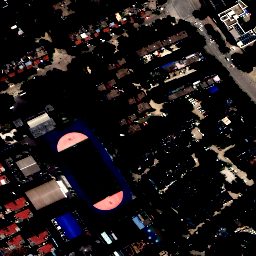

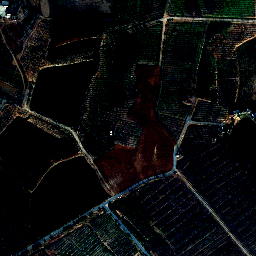

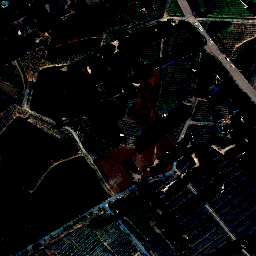

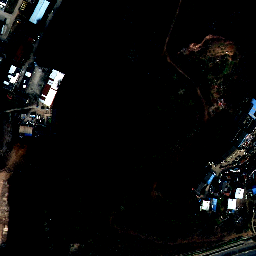

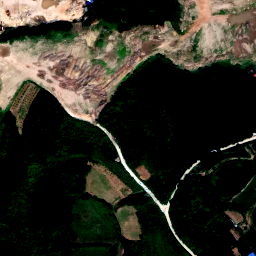

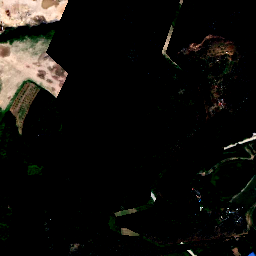

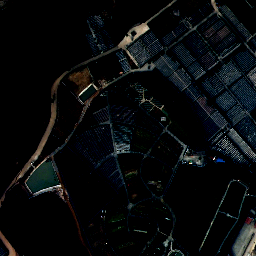

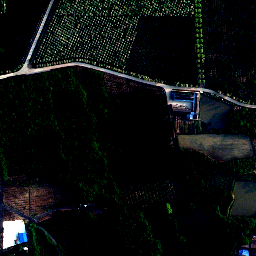

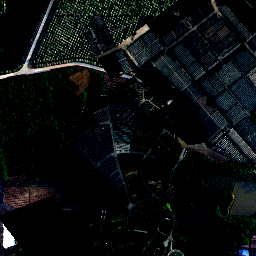

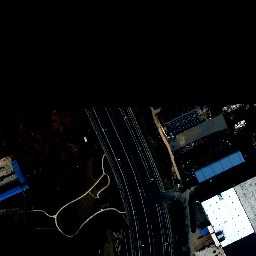

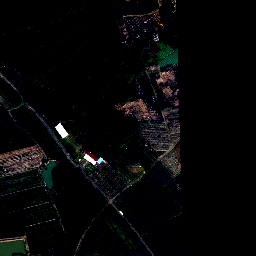

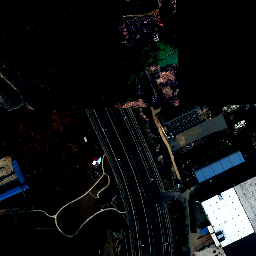

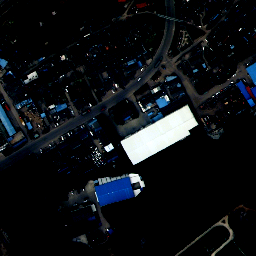

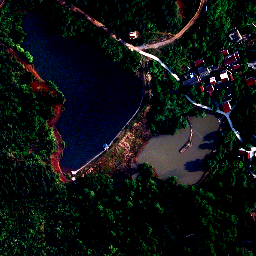

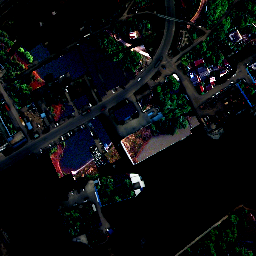

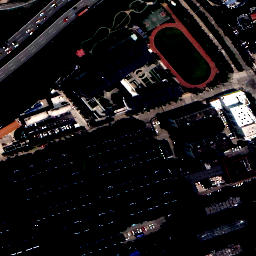

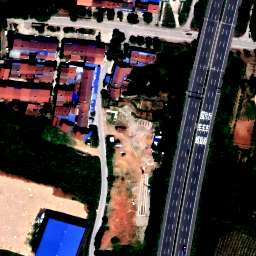

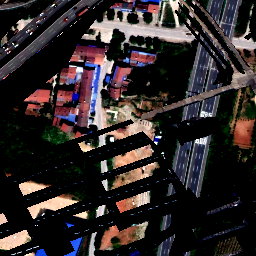

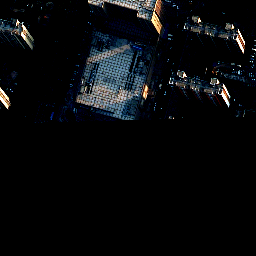

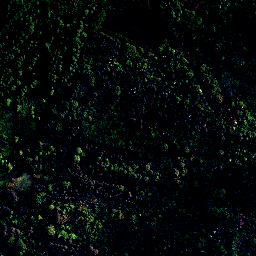

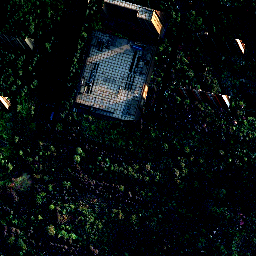

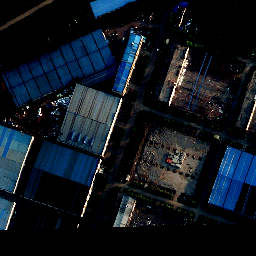

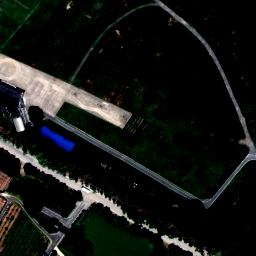

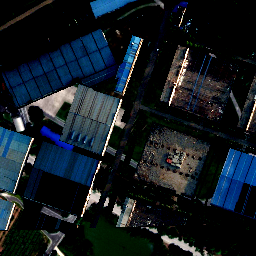

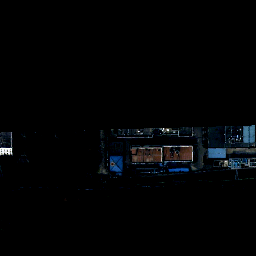

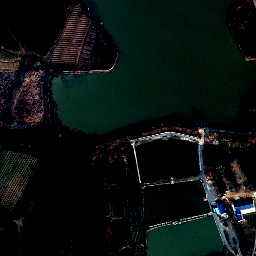

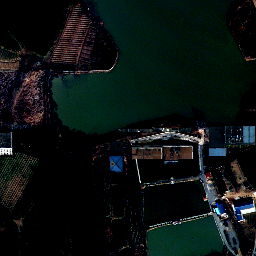

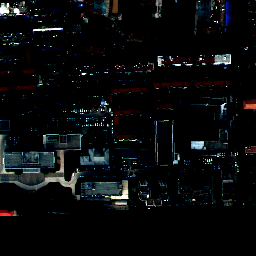

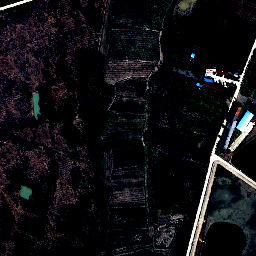

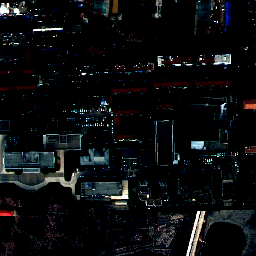

KeyboardInterrupt: 

In [75]:
import warnings
from torch.backends import cudnn

warnings.filterwarnings('ignore')
cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH).to(DEVICE)

iterPerEpoch = len(urban_train_dataloader_augmented)

best_IoU = 0

IMG_SAMPLES = (1,2,3,4,5,6,7,8,9,10)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    td_iter = iter(rural_train_dataloader) # target domain iter

    for i, (source_inputs, source_labels) in enumerate(urban_train_dataloader_augmented):
        optimizer_fn.zero_grad()

        # ---- gets Xs,Ys
        source_inputs = source_inputs.to(DEVICE)
        source_labels = source_labels.long().to(DEVICE)

        # ---- output size information
        h, w = source_labels.size(1), source_labels.size(2)

        # ---- gets Xt
        try:
            batch = next(td_iter)
            if batch[0].shape[0] != BATCH_SIZE:
                batch = next(td_iter)
        except:
            td_iter = iter(rural_train_dataloader) # restart
            batch = next(td_iter)

        target_inputs,_ = batch # discard target labels to perform as DA is UNSUPERVISED
        target_inputs = target_inputs.to(DEVICE)
        target_outputs,_,_ = model(target_inputs)
        # check for interpolation
        toh, tow = target_outputs.size(2), target_outputs.size(3)
        if toh != h or tow != w:
          target_outputs = F.interpolate(target_outputs, size=(h, w), mode='bilinear', align_corners=True)

        # ---- Calculate confidence for pseudo-labeling
        with torch.no_grad():
            target_confidences = F.softmax(target_outputs, dim=1).max(dim=1)[0]  # Max confidence per pixel
            confident_mask = (target_confidences > PIXEL_CONFIDENCE_THRESHOLD).float()
            LAMBDA = confident_mask.mean().item()  # Proportion of confident pixels

        #print(Fore.WHITE+Style.DIM+f"LAMBDA={LAMBDA}"+Style.RESET_ALL)

        # ---- get Y't
        _,target_pseudo_labels = torch.max(target_outputs.data, 1)

        # ---- virtually creates (Xm,Ym) from (Xs,Ys) and (Xt,Y't)
        mixed_inputs, mixed_labels = DACS_mix_batches(source_inputs,source_labels,target_inputs,target_pseudo_labels)
        if i in IMG_SAMPLES:
          visualize_tensor(source_inputs[0])
          visualize_tensor(target_inputs[0])
          visualize_tensor(mixed_inputs[0])


        # augments both (Xs,Ys) and (Xm,Ym) and put them into GPU
        source_inputs,source_labels = batch_core_trf(source_inputs, source_labels)
        mixed_inputs,mixed_labels = batch_core_trf(mixed_inputs, mixed_labels)

        # feeds in the model with both Xs and Xm
        source_outputs,_,_ = model(source_inputs)
        mixed_outputs,_,_ = model(mixed_inputs)

        # check for interpolation
        soh, sow = source_outputs.size(2), source_outputs.size(3)
        if soh != h or sow != w:
          source_outputs = F.interpolate(source_outputs, size=(h, w), mode='bilinear', align_corners=True)
        moh, mow = mixed_outputs.size(2), mixed_outputs.size(3)
        if moh != h or mow != w:
          mixed_outputs = F.interpolate(mixed_outputs, size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        source_loss = sloss_fn(source_outputs, source_labels)
        mixed_loss = tloss_fn(mixed_outputs, mixed_labels)
        loss = source_loss + LAMBDA*mixed_loss

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        # compute the training accuracy
        _, source_predicted = torch.max(source_outputs.data, 1)
        _, mixed_predicted = torch.max(mixed_outputs.data, 1)

        iou_meter.addCouple(source_predicted,source_labels)
        iou_meter.addCouple(mixed_predicted,mixed_labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(rural_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, targets) in enumerate(rural_val_dataloader):

            # feeds in model
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(device=DEVICE)
            outputs,_,_ = model(inputs)
            outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # compute loss
            loss = sem_criterion(outputs, labels)

            # compute the training accuracy
            _, predicted = torch.max(outputs.data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()
        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

optim_scheduler.step()
# END OF TRAINING


testing

In [ ]:
# TESTING ON BEST WEIGHTS
print(Fore.BLACK+Back.CYAN+Style.BRIGHT+f"Testing PIDNet with LoveDA-URBAN with augmentation v{i+1}"+Style.RESET_ALL)
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(rural_val_dataloader)
iou_meter = IoUMeter()
for j, (inputs, targets) in enumerate(rural_val_dataloader):

    # feeds in model
    inputs = inputs.to(DEVICE)
    labels = targets.long().to(device=DEVICE)
    outputs,_,_ = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

    # compute loss
    loss = sem_criterion(outputs, labels)


    # compute the training accuracy
    _, predicted = torch.max(outputs.data, 1)

    iou_meter.addCouple(predicted,labels)

    step_loss = loss.data.item()
    val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)
# END OF TESTING

## 5

In [ ]:

import cv2
def canny_with_cv2(images_tensors, low_threshold=0.1, high_threshold=0.2):
    # Convert to NumPy
    edges_tensors = images_tensors.clone().cpu()
    for i,img in enumerate(edges_tensors):
      # Convert to NumPy
      image_np = img.numpy()
      edges_np = cv2.Canny((image_np*255).astype('uint8'), low_threshold, high_threshold)

      # Convert back to tensor
      edges_tensors[i] = torch.from_numpy(edges_np).float() / 255.0
    return edges_tensors